# Wheat Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

Connect to Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


 **GPU less use**

unzip dataset

In [ ]:
import zipfile

# Provide the path to the uploaded zip file
zip_path = '/content/drive/MyDrive/Wheat_random.zip'

# Specify the destination directory to extract the files
extract_path = '/content/drive/MyDrive'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


### Import all the Dependencies

In [45]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [100]:
BATCH_SIZE = 23
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=35

Resize Images in DataSet

In [ ]:
from PIL import Image, UnidentifiedImageError
import os

SIZE = [224, 224]
folders = ['Healthy', 'septoria', 'stripe_rust', 'random']
base_path = '/content/drive/MyDrive/wheat_leaf2'  # Specify the base directory path

for folder in folders:
    folder_path = os.path.join(base_path, folder)

    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)

        try:
            image = Image.open(image_path)
            resized_image = image.resize(SIZE)

            # Check if the original image format is JPEG
            if image.format.lower() != 'jpeg':
                raise ValueError(f"Unsupported image format {image.format}. Only JPEG images are allowed.")

            # Save the resized image as JPEG, overwriting the original image
            resized_image.save(image_path, format='JPEG')

            print(f"Resized {folder} image: {filename}")
        except (UnidentifiedImageError, OSError, ValueError) as e:
            # Handle the error, print a message, and delete the problematic image
            print(f"Error processing {folder} image: {filename}. Deleting. Error: {e}")
            os.remove(image_path)


Streaming output truncated to the last 5000 lines.
Resized random image: image_05677.jpg
Resized random image: image_05678.jpg
Resized random image: image_05679.jpg
Resized random image: image_05680.jpg
Resized random image: image_05681.jpg
Resized random image: image_05682.jpg
Resized random image: image_05683.jpg
Resized random image: image_05684.jpg
Resized random image: image_05685.jpg
Resized random image: image_05686.jpg
Resized random image: image_05687.jpg
Resized random image: image_05688.jpg
Resized random image: image_05689.jpg
Resized random image: image_05690.jpg
Resized random image: image_05691.jpg
Resized random image: image_05692.jpg
Resized random image: image_05693.jpg
Resized random image: image_05694.jpg
Resized random image: image_05695.jpg
Resized random image: image_05696.jpg
Resized random image: image_05697.jpg
Resized random image: image_05698.jpg
Resized random image: image_05699.jpg
Resized random image: image_05700.jpg
Resized random image: image_05701.jpg

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Path to the directory containing your original images
#original_dataset_dir = '/content/drive/MyDrive/wheat_leaf2/Healthy'
#original_dataset_dir = '/content/drive/MyDrive/wheat_leaf2/septoria'
original_dataset_dir = '/content/drive/MyDrive/wheat_leaf2/stripe_rust'

# Number of augmented images to generate per original image
augmentation_factor = 5

# Create the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rescale=1./225,
    rotation_range=60,
    width_shift_range=0.1,  # Reduce width shift range
    height_shift_range=0.1,  # Reduce height shift range
    shear_range=0.1,  # Reduce shear range
    zoom_range=0.001,  # Reduce zoom range
    horizontal_flip=True,
    vertical_flip=True
)

# Load the original images from the directory
image_count = 0
for root, dirs, files in os.walk(original_dataset_dir):
    for file in files:
        # Load the image
        img = load_img(os.path.join(root, file))
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)  # Reshape to (1, height, width, channels)

        # Generate augmented images
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=root, save_prefix='aug', save_format='jpg'):
            i += 1
            image_count += 1
            if i >= augmentation_factor:
                break  # Break the loop after generating desired number of augmented images

print("Total number of images after augmentation:", image_count)


Total number of images after augmentation: 11235


### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [101]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/wheat_leaf2",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7900 files belonging to 4 classes.


Name of Folder in Main Wheat Folder which are classes

In [102]:
class_names = dataset.class_names
class_names

['Healthy', 'random', 'septoria', 'stripe_rust']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())#get every element in form of tensor so convert in numpy

As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

### Visualize some of the images from our dataset

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:
len(dataset)

2666

In [ ]:
train_size = 0.8
len(dataset)*train_size

2132.8

In [ ]:
train_ds = dataset.take(2132)
len(train_ds)

2132

In [ ]:
test_ds = dataset.skip(2132)
len(test_ds)

534

In [ ]:
val_size=0.1
len(dataset)*val_size

266.6

In [ ]:
val_ds = test_ds.take(266)
len(val_ds)

266

In [ ]:
test_ds = test_ds.skip(266)
len(test_ds)

268

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

In [ ]:
len(val_ds)

In [ ]:
len(test_ds)

### Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size.
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 225).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (225,225) image to again (225,225). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (225,225) and this layer will resize it

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./225),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.1),
])

#### Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
#train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:

tf.__version__

'2.15.0'

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (24, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (24, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (24, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (24, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (24, 54, 54, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (24, 52, 52, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [82]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()


In [83]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/22
144/144 [==============================] - 588s 4s/step - loss: 0.9515 - accuracy: 0.5444 - val_loss: 0.7007 - val_accuracy: 0.6594
Epoch 2/22
144/144 [==============================] - 50s 341ms/step - loss: 0.6150 - accuracy: 0.7500 - val_loss: 0.5370 - val_accuracy: 0.7657
Epoch 3/22
144/144 [==============================] - 51s 346ms/step - loss: 0.4804 - accuracy: 0.8185 - val_loss: 0.5377 - val_accuracy: 0.7681
Epoch 4/22
144/144 [==============================] - 50s 341ms/step - loss: 0.4331 - accuracy: 0.8475 - val_loss: 0.4158 - val_accuracy: 0.8454
Epoch 5/22
144/144 [==============================] - 51s 349ms/step - loss: 0.3779 - accuracy: 0.8626 - val_loss: 0.2360 - val_accuracy: 0.9106
Epoch 6/22
144/144 [==============================] - 51s 346ms/step - loss: 0.3226 - accuracy: 0.8829 - val_loss: 0.2841 - val_accuracy: 0.8986
Epoch 7/22
144/144 [==============================] - 41s 281ms/step - loss: 0.2907 - accuracy: 0.8976 - val_loss: 0.3130 - val_accu

In [84]:
scores = model.evaluate(test_ds)

18/18 [==============================] - 13s 41ms/step - loss: 0.2224 - accuracy: 0.9284


**You can see above that we get 100.00% accuracy for our test dataset. **

In [86]:
scores

[0.22238436341285706, 0.9283950328826904]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [87]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [88]:
history.params

{'verbose': 1, 'epochs': 22, 'steps': 144}

In [89]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [90]:
type(history.history['loss'])

list

In [91]:
len(history.history['loss'])

22

In [92]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9514584541320801,
 0.6149802207946777,
 0.48035940527915955,
 0.4330731928348541,
 0.3779119551181793]

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

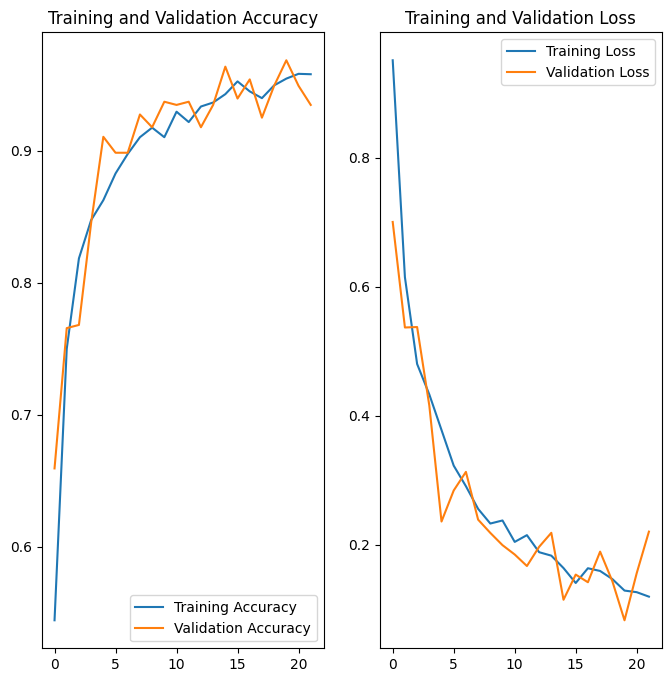

In [94]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: stripe_rust
1/1 [==============================] - 0s 193ms/step
predicted label: septoria


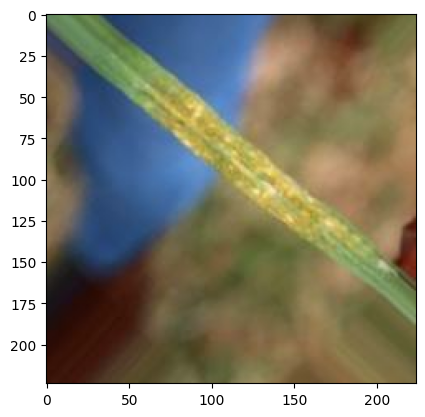

In [95]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [96]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 19ms/step


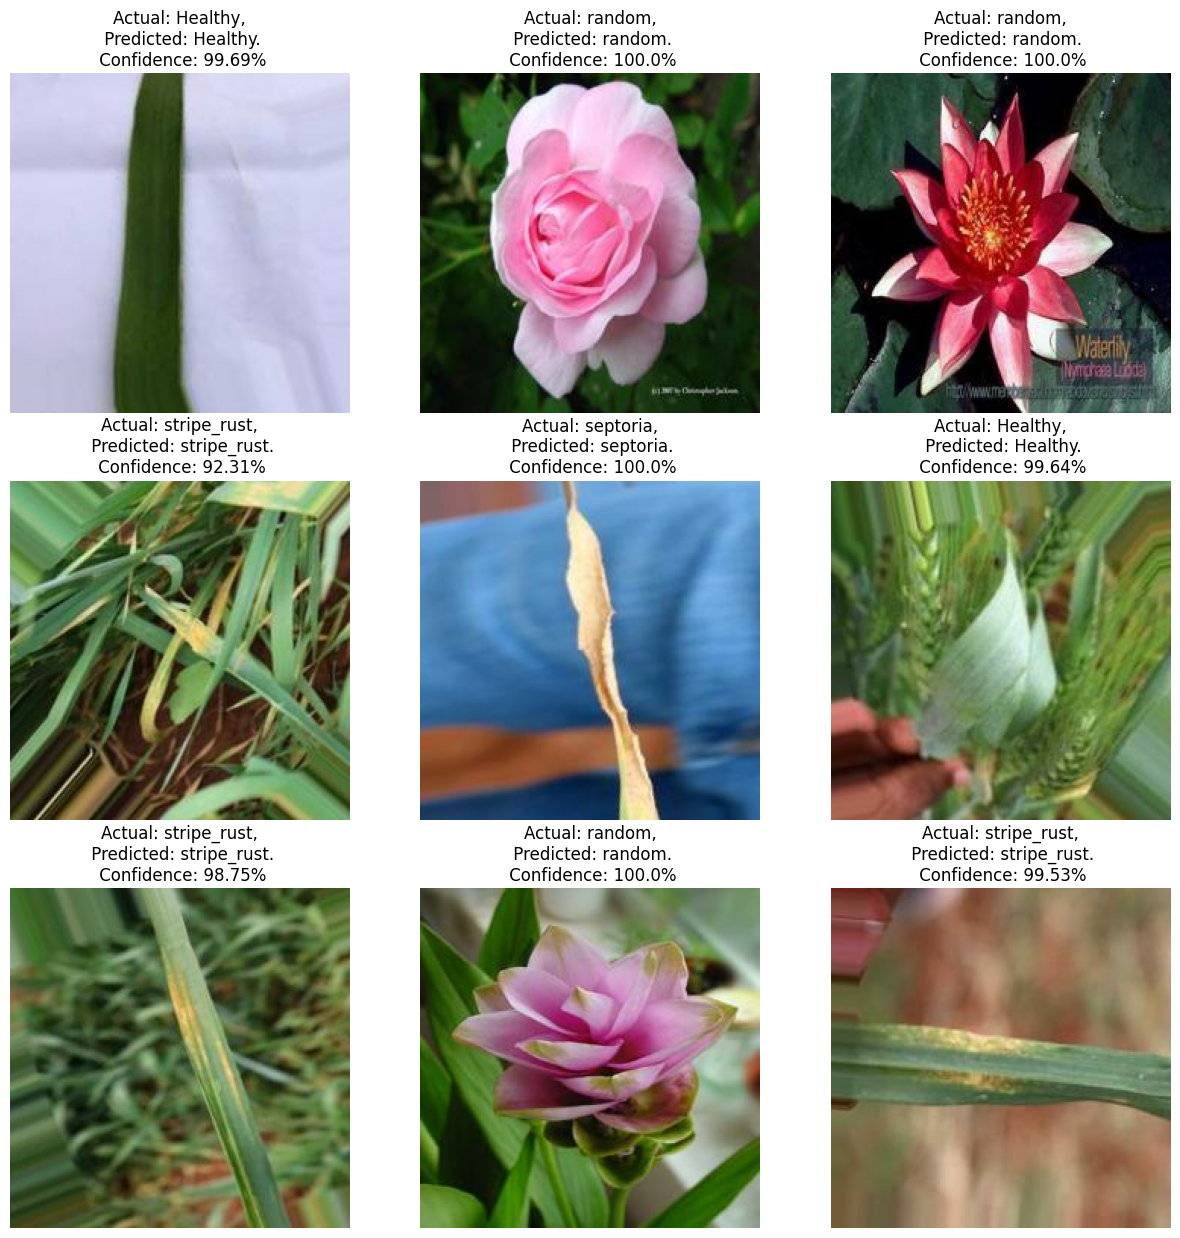

In [97]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [98]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/model") + [0]])+1
model.save(f"/content/drive/MyDrive/model/{model_version}")

In [99]:
model.save("../wheat.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
